In [1]:
# ジャーク最小化モデルを使用した解析

In [2]:
## データの作成

In [23]:
import numpy as np
import pandas as pd

# 設定
sampling_rate = 100  # Hz
reach_time = 10
duration = 5  # 秒
np.random.seed(42)

# 軌道生成関数 (最小Jerk軌道に近い滑らかな動き)
def generate_smooth_trajectory(start, end, t):
    T = t[-1]  # 終了時間
    tau = t / T
    position = start + (end - start) * (10*tau**3 - 15*tau**4 + 6*tau**5)
    return position

save_df = pd.DataFrame()
count_n = 1
for i in range(reach_time):
    num_samples = sampling_rate * (duration - np.random.randn())  # サンプル数
    time = np.arange(0, num_samples, 1/sampling_rate)  # 時間配列
    # 各関節の開始・終了位置
    shoulder_start, shoulder_end = np.array([0.0, 0.3, 1.5])+np.random.random((3,))/10, np.array([0.0, 0.35, 1.55])+np.random.random((3,))/10
    elbow_start, elbow_end = np.array([0.1, 0.2, 1.2])+np.random.random((3,))/10, np.array([0.15, 0.25, 1.25])+np.random.random((3,))/10
    wrist_start, wrist_end = np.array([0.2, 0.1, 0.9])+np.random.random((3,))/10, np.array([0.3, 0.15, 1.0])+np.random.random((3,))/10

    # 軌道データ生成
    shoulder_traj = np.array([generate_smooth_trajectory(shoulder_start[i], shoulder_end[i], time) for i in range(3)]).T
    elbow_traj = np.array([generate_smooth_trajectory(elbow_start[i], elbow_end[i], time) for i in range(3)]).T
    wrist_traj = np.array([generate_smooth_trajectory(wrist_start[i], wrist_end[i], time) for i in range(3)]).T

    # データフレーム作成
    df = pd.DataFrame({
        "time": time,
        "shoulder_x": shoulder_traj[:, 0], "shoulder_y": shoulder_traj[:, 1], "shoulder_z": shoulder_traj[:, 2],
        "elbow_x": elbow_traj[:, 0], "elbow_y": elbow_traj[:, 1], "elbow_z": elbow_traj[:, 2],
        "wrist_x": wrist_traj[:, 0], "wrist_y": wrist_traj[:, 1], "wrist_z": wrist_traj[:, 2]
    })
    df['Timing'] = count_n
    save_df = pd.concat([save_df,df])
    count_n += 1

# CSVに保存
csv_filename = "reaching_trajectory.csv"
save_df.to_csv(csv_filename, index=False)

print(f"サンプルデータを {csv_filename} に保存しました。")

サンプルデータを reaching_trajectory.csv に保存しました。


In [24]:
elbow_measured = df[["elbow_x", "elbow_y", "elbow_z"]].values

,time,shoulder_x,shoulder_y,shoulder_z,elbow_x,elbow_y,elbow_z,wrist_x,wrist_y,wrist_z,Timing
0,0.00,0.073199,0.359866,1.515602,0.160112,0.270807,1.202058,0.218182,0.118340,0.930424,1
1,0.01,0.073199,0.359866,1.515602,0.160112,0.270807,1.202058,0.218182,0.118340,0.930424,1
2,0.02,0.073199,0.359866,1.515602,0.160112,0.270807,1.202058,0.218182,0.118340,0.930424,1
3,0.03,0.073199,0.359866,1.515602,0.160112,0.270807,1.202058,0.218182,0.118340,0.930424,1
4,0.04,0.073199,0.359866,1.515602,0.160112,0.270807,1.202058,0.218182,0.118340,0.930424,1
...,...,...,...,...,...,...,...,...,...,...,...
42476,424.76,0.013752,0.384107,1.561347,0.215998,0.331722,1.305520,0.389722,0.240042,1.063310,10
42477,424.77,0.013752,0.384107,1.561347,0.215998,0.331722,1.305520,0.389722,0.240042,1.063310,10
42478,424.78,0.013752,0.384107,1.561347,0.215998,0.331722,1.305520,0.389722,0.240042,1.063310,10
42479,424.79,0.013752,0.384107,1.561347,0.215998,0.331722,1.305520,0.389722,0.240042,1.063310,10


In [26]:
## データの読み取り

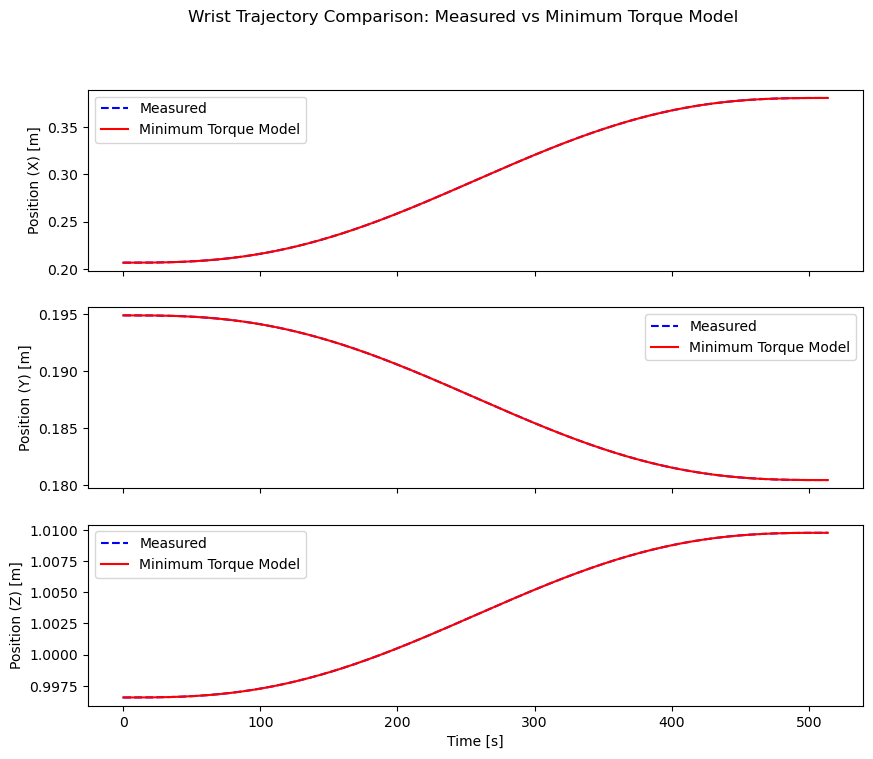

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# CSVデータの読み込み
csv_filename = "reaching_trajectory.csv"
df = pd.read_csv(csv_filename)

df = df.loc[df['Timing']==2]
# 時間データ
time = df["time"].values

# 測定された手首の軌道
wrist_measured = df[["wrist_x", "wrist_y", "wrist_z"]].values

# --- 最小トルクモデルによる理想軌道の生成 ---
# 最小トルク軌道を求めるための関数
def min_torque_trajectory(t, start, end):
    T = t[-1]
    tau = t / T
    position = start + (end - start) * (6*tau**5 - 15*tau**4 + 10*tau**3)
    return position

# 手首の開始・終了位置
wrist_start = wrist_measured[0]
wrist_end = wrist_measured[-1]

# 最小トルク軌道の計算
wrist_mtm = np.array([min_torque_trajectory(time, wrist_start[i], wrist_end[i]) for i in range(3)]).T

# --- プロットによる比較 ---
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

labels = ['X', 'Y', 'Z']
for i in range(3):
    ax[i].plot(time, wrist_measured[:, i], label="Measured", linestyle="dashed", color="blue")
    ax[i].plot(time, wrist_mtm[:, i], label="Minimum Torque Model", color="red")
    ax[i].set_ylabel(f"Position ({labels[i]}) [m]")
    ax[i].legend()

ax[-1].set_xlabel("Time [s]")
plt.suptitle("Wrist Trajectory Comparison: Measured vs Minimum Torque Model")
plt.show()

In [ ]:
for i in range(3):
    ax[i].plot(time, wrist_measured[:, i], label="Measured", linestyle="dashed", color="blue")
    ax[i].plot(time, wrist_mtm[:, i], label="Minimum Torque Model", color="red")
    ax[i].set_ylabel(f"Position ({labels[i]}) [m]")
    ax[i].legend()

ax[-1].set_xlabel("Time [s]")
plt.suptitle("Wrist Trajectory Comparison: Measured vs Minimum Torque Model")
plt.show()

In [31]:
# 2関節モデルのパラメータ（仮定）
L1 = 0.5  # 上腕の長さ [m]
L2 = 0.5  # 前腕の長さ [m]

# 時間データ
time = np.linspace(0, 1, 1000)  # 1秒間の軌道、1000ポイント

# 最小トルクモデルによる関節角度の計算
def min_torque_trajectory(t, theta_start, theta_end):
    tau = t
    return theta_start + (theta_end - theta_start) * (6*tau**5 - 15*tau**4 + 10*tau**3)

# 肩と肘の初期・最終角度（仮定）
shoulder_measured = df[["shoulder_x", "shoulder_y", "shoulder_z"]].values
theta1_start = 0  # 肩の初期位置
theta1_end = np.pi / 4  # 肩の最終角度 [rad]
elbow_measured = df[["elbow_x", "elbow_y", "elbow_z"]].values
theta2_start = 0  # 肘の初期角度 [rad]
theta2_end = np.pi / 4  # 肘の最終角度 [rad]

# 肩と肘の理想的な軌道
theta1_trajectory = min_torque_trajectory(time, theta1_start, theta1_end)
theta2_trajectory = min_torque_trajectory(time, theta2_start, theta2_end)

# 手首の位置（順運動学）
x_wrist = L1 * np.cos(theta1_trajectory) + L2 * np.cos(theta1_trajectory + theta2_trajectory)
y_wrist = L1 * np.sin(theta1_trajectory) + L2 * np.sin(theta1_trajectory + theta2_trajectory)

# プロット
plt.figure(figsize=(10, 8))

# 手首のX-Y軌道
plt.subplot(2, 1, 1)
plt.plot(x_wrist, y_wrist, label="Ideal Wrist Trajectory", color="red")
plt.title("Ideal Wrist Trajectory (2-Joint Model)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()

# 各関節角度の推移
plt.subplot(2, 1, 2)
plt.plot(time, theta1_trajectory, label="Shoulder Angle (θ1)", color="blue")
plt.plot(time, theta2_trajectory, label="Elbow Angle (θ2)", color="green")
plt.title("Joint Angles (2-Joint Model)")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")
plt.legend()

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (3,) (1000,) 